In [8]:
# --- Core Libraries ---
import os
import random
import pickle
from collections import OrderedDict

# --- Numerical and Scientific Libraries ---
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter

# --- Machine Learning and Deep Learning ---
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18
from sklearn.metrics import roc_auc_score, roc_curve

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm

# --- Custom Dataloader ---
# Make sure your bowtie.py file is in a folder named 'datasets'
import datasets.bowtie as bowtie

# --- Device Configuration ---
# Set the computation device (GPU if available, otherwise CPU)
IS_CUDA_AVAILABLE = torch.cuda.is_available()
DEVICE = torch.device('cuda' if IS_CUDA_AVAILABLE else 'cpu')
print(f"--- Running on device: {DEVICE} ---")

--- Running on device: cuda ---


Good practice in notebooks is to keep all your main parameters in one place. This makes it easy to experiment with different settings without hunting through the code.

In [9]:
# --- Model & Feature Parameters ---
# The pre-trained network architecture to use.
# 'wide_resnet50_2' is generally more powerful but slower. 'resnet18' is faster.
MODEL_ARCHITECTURE = "wide_resnet50_2"
# These dimensions are specific to the chosen architecture.
# TOTAL_FEATURE_DIMENSION: The combined number of channels from the layers we extract.
# REDUCED_FEATURE_DIMENSION: The number of random features we select to model.
if MODEL_ARCHITECTURE == "wide_resnet50_2":
    TOTAL_FEATURE_DIMENSION = 1792
    REDUCED_FEATURE_DIMENSION = 550
else: # resnet18
    TOTAL_FEATURE_DIMENSION = 448
    REDUCED_FEATURE_DIMENSION = 100

# --- Dataset & Path Parameters ---
# The specific class within your dataset to train and test on.
CLASS_NAME = "116"
# Root path to your dataset.
DATA_PATH = "../anomaly_detection/data/BowTie-New/original"
# Directory where all results, cached files, and images will be saved.
BASE_RESULTS_DIR = "./results"

# --- Image Preprocessing Parameters ---
# The size images are resized to before being cropped.
RESIZE = 256
# The final size of the image fed into the model. Must match model's expected input.
CROPSIZE = 256

# --- Reproducibility ---
# Setting a seed ensures you get the same 'random' results every time you run the code.
RANDOM_SEED = 1024

# Create a unique name for this experiment run
experiment_name = f"{MODEL_ARCHITECTURE}_resize-{RESIZE}_crop-{CROPSIZE}"

# Define the master directory for this experiment
MASTER_SAVE_DIR = os.path.join(BASE_RESULTS_DIR, experiment_name)

# Define the specific directory for the current class
CLASS_SAVE_DIR = os.path.join(MASTER_SAVE_DIR, CLASS_NAME)

# Create the directories if they don't exist
os.makedirs(CLASS_SAVE_DIR, exist_ok=True)

print(f"All results for this run will be saved in: {MASTER_SAVE_DIR}")
print(f"Results for class '{CLASS_NAME}' will be in: {CLASS_SAVE_DIR}")

All results for this run will be saved in: ./results/wide_resnet50_2_resize-256_crop-256
Results for class '116' will be in: ./results/wide_resnet50_2_resize-256_crop-256/116


These are utility functions that we'll use throughout the notebook. They handle tasks like plotting results and combining feature maps.

The **embedding_concat** function is particularly important.

Our ResNet model produces feature maps of different spatial sizes at different layers (e.g., Layer 1 might be 100x100, Layer 2 is 50x50). To combine them, we can't just stack them. This function uses a clever method to align and concatenate them into a single, rich feature vector for every location.

In [10]:
def denormalize_image_for_display(tensor_image):
    """
    Reverses the normalization applied to an image tensor to make it viewable.
    
    Args:
        tensor_image (np.ndarray): A normalized image tensor in (C, H, W) format.

    Returns:
        np.ndarray: The denormalized image in (H, W, C) uint8 format.
    """
    # ImageNet normalization statistics
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Transpose from (C, H, W) to (H, W, C), multiply by std, add mean, and scale to 0-255
    denormalized_img = (((tensor_image.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)
    return denormalized_img


def concatenate_embeddings(larger_feature_map, smaller_feature_map):
    """
    Aligns and concatenates two feature maps of different spatial resolutions.
    """
    # Get dimensions
    B, C1, H1, W1 = larger_feature_map.size()
    _, C2, H2, W2 = smaller_feature_map.size()
    
    # Use F.unfold to extract patches from the larger map that align with pixels in the smaller map
    stride = int(H1 / H2)
    unfolded_larger_map = F.unfold(larger_feature_map, kernel_size=stride, dilation=1, stride=stride)
    unfolded_larger_map = unfolded_larger_map.view(B, C1, -1, H2, W2)
    
    # Concatenate the smaller map to each of the patches from the larger map
    concatenated_tensor = torch.zeros(B, C1 + C2, unfolded_larger_map.size(2), H2, W2)
    for i in range(unfolded_larger_map.size(2)):
        patch = unfolded_larger_map[:, :, i, :, :]
        concatenated_tensor[:, :, i, :, :] = torch.cat((patch, smaller_feature_map), 1)
        
    # Use F.fold to reconstruct the full-size feature map from the concatenated patches
    concatenated_tensor = concatenated_tensor.view(B, -1, H2 * W2)
    final_embedding = F.fold(concatenated_tensor, kernel_size=stride, output_size=(H1, W1), stride=stride)
    
    return final_embedding

Here, we load our pre-trained ResNet model. We are not training the model itself; instead, we are using it as a powerful, off-the-shelf **feature extractor**.

To get the rich, multi-level features PaDiM needs, we use **PyTorch Hooks**. A hook is like a little spy we can attach to any layer in the network. When the model processes an image, our hook will automatically grab the output of that layer for us without interrupting the flow. We are attaching hooks to the end of layers 1, 2, and 3.

In [11]:
# --- Load Pre-trained Model ---
print(f"Loading pre-trained model: {MODEL_ARCHITECTURE}")
if MODEL_ARCHITECTURE == "wide_resnet50_2":
    model = wide_resnet50_2(pretrained=True, progress=True)
else:
    model = resnet18(pretrained=True, progress=True)

model.to(DEVICE)
model.eval()  # Set the model to evaluation mode (crucial!)

# --- Set Seeds for Reproducibility ---
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if IS_CUDA_AVAILABLE:
    torch.cuda.manual_seed_all(RANDOM_SEED)

# --- Random Feature Selection ---
# PaDiM randomly selects a subset of the feature channels to model.
# This reduces memory and computation while maintaining high performance.
print(f"Randomly selecting {REDUCED_FEATURE_DIMENSION} features from a total of {TOTAL_FEATURE_DIMENSION}.")
random_feature_indices = torch.tensor(
    random.sample(range(0, TOTAL_FEATURE_DIMENSION), REDUCED_FEATURE_DIMENSION)
)

# --- Setup Hooks to Extract Intermediate Features ---
# This list will store the feature maps captured by our hooks.
intermediate_feature_maps = []
def hook_function(module, input, output):
    """A simple hook that appends the output of a layer to a list."""
    intermediate_feature_maps.append(output)

# Register the hook function on the final block of the first three layers.
model.layer1[-1].register_forward_hook(hook_function)
model.layer2[-1].register_forward_hook(hook_function)
model.layer3[-1].register_forward_hook(hook_function)

Loading pre-trained model: wide_resnet50_2


/home/mikeszklarz/anaconda3/envs/padim/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mikeszklarz/anaconda3/envs/padim/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Randomly selecting 550 features from a total of 1792.


Now we'll prepare our datasets. We create two instances of our **BowtieDataset**: one for training (containing only normal images) and one for testing (containing a mix of normal and abnormal images). The **DataLoader** then wraps these datasets to efficiently feed batches of images to the model.

In [12]:
# --- Create the Data Manager and DataLoaders ---
print("Initializing the Bowtie Data Manager...")

# Initialize the manager once. It handles all the splitting internally.
data_manager = bowtie.BowtieDataManager(
    dataset_path=DATA_PATH,
    class_name=CLASS_NAME,
    resize=RESIZE,
    cropsize=CROPSIZE,
    augmentations_enabled=True,
    horizontal_flip=True,
    vertical_flip=False,
    augmentation_prob=0.5,
    seed=RANDOM_SEED
)

# Create DataLoaders directly from the manager's attributes
train_dataloader = DataLoader(data_manager.train, batch_size=32, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(data_manager.test, batch_size=32, pin_memory=True)

Initializing the Bowtie Data Manager...


In [13]:
data_manager.print_dataset_summary()

--- Bowtie Dataset Summary ---
Dataset path (root): /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/original/116/train
Total images discovered (train+test): 136
 - Train images: 100
 - Test images:  36 (Normal: 26, Abnormal: 10)

Training augmentation settings:
 - Augmentations enabled: True
 - Horizontal flip:      True
 - Vertical flip:        False
 - Augmentation prob:    0.5
 - Expected augmented images per epoch (approx): 50 of 100
-------------------------------


In [14]:
data_manager.print_train_files()

File: ../anomaly_detection/data/BowTie-New/original/116/train/good/023.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/097.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/101.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/038.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/116.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/072.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/051.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/056.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/082.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/034.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/036.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/goo

In [15]:
data_manager.print_test_files()

File: ../anomaly_detection/data/BowTie-New/original/116/train/good/132.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/022.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/107.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/135.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/128.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/131.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/134.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/053.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/103.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/130.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/good/104.jpg, Label: 0
File: ../anomaly_detection/data/BowTie-New/original/116/train/goo

This is the core training step of PaDiM. We will process all normal images from the train_dataloader and perform the following actions:

1. **Extract Features**: Pass each image through the ResNet model. Our hooks will capture the feature maps from layers 1, 2, and 3.

2. **Concatenate & Reduce**: Combine the feature maps using our concatenate_embeddings function and then select the random subset of channels we chose earlier.

3. **Calculate Statistics**: For each patch location in the feature map, we compute the mean and covariance across all training images. This collection of means and covariances is our learned model of normalcy.

4. **Cache Results**: We save this statistical model to a .pkl file so we don't have to re-compute it every time we run the notebook.

In [16]:
# --- Learn the Distribution of Normal Features ---

# Path for the cached statistical model in the class-specific directory
learned_distribution_path = os.path.join(CLASS_SAVE_DIR, 'learned_distribution.pkl')

if not os.path.exists(learned_distribution_path):
    print("No cached distribution found. Learning from scratch...")
    
    # Dictionaries to store features from each layer
    train_feature_maps = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])
    
    # --- 1. Feature Extraction ---
    for (image_batch, _, _) in tqdm(train_dataloader, desc="Extracting training features"):
        with torch.no_grad():
            # This forward pass triggers the hooks
            _ = model(image_batch.to(DEVICE))
        
        # Store the captured feature maps
        for layer_name, feature_map in zip(train_feature_maps.keys(), intermediate_feature_maps):
            train_feature_maps[layer_name].append(feature_map.cpu().detach())
        
        # Reset the list for the next batch
        intermediate_feature_maps = []
        
    for layer_name, feature_list in train_feature_maps.items():
        train_feature_maps[layer_name] = torch.cat(feature_list, 0)

    # --- 2. Concatenation and Reduction ---
    # Combine features from the three layers
    embedding_vectors = train_feature_maps['layer1']
    for layer_name in ['layer2', 'layer3']:
        embedding_vectors = concatenate_embeddings(embedding_vectors, train_feature_maps[layer_name])

    # Select the random subset of feature channels
    embedding_vectors = torch.index_select(embedding_vectors, 1, random_feature_indices)
    
    # --- 3. Statistical Calculation (Mean and Covariance) ---
    B, C, H, W = embedding_vectors.size()
    embedding_vectors = embedding_vectors.view(B, C, H * W)
    
    mean_vectors = torch.mean(embedding_vectors, dim=0).numpy()
    
    # Calculate covariance matrix for each patch location
    covariance_matrices = torch.zeros(C, C, H * W).numpy()
    identity_matrix = np.identity(C)
    for i in range(H * W):
        # Add a small value (0.01 * I) for numerical stability, ensuring the matrix is invertible
        patch_embeddings = embedding_vectors[:, :, i].numpy()
        covariance_matrices[:, :, i] = np.cov(patch_embeddings, rowvar=False) + 0.01 * identity_matrix
    
    # This list contains our learned model: the mean and covariance for every patch.
    learned_distribution = [mean_vectors, covariance_matrices]
    
    # --- 4. Caching ---
    print(f"Saving learned distribution to: {learned_distribution_path}")
    with open(learned_distribution_path, 'wb') as f:
        pickle.dump(learned_distribution, f)
else:
    print(f"Loading cached distribution from: {learned_distribution_path}")
    with open(learned_distribution_path, 'rb') as f:
        learned_distribution = pickle.load(f)

print("--- Learning of 'normal' distribution complete. ---")

No cached distribution found. Learning from scratch...


Extracting training features: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Saving learned distribution to: ./results/wide_resnet50_2_resize-256_crop-256/116/learned_distribution.pkl
--- Learning of 'normal' distribution complete. ---


What does a neural network "see"? A feature map is the output of a network layer. You can think of each channel in the feature map as a filter that has learned to detect a specific pattern (an edge, a curve, a texture). Here, we'll run a single image through the model and visualize the first few channels from each layer's feature map.

After processing all the normal training images, we calculated a **mean_vectors** array. This represents the "average" or "ideal" feature for every single patch location. By reshaping it back into an image-like format, we can visualize this "blueprint of normalcy."


--- Visualization 4: The Learned 'Normal' Mean Feature Map ---
Mean array shape: (550, 4096)


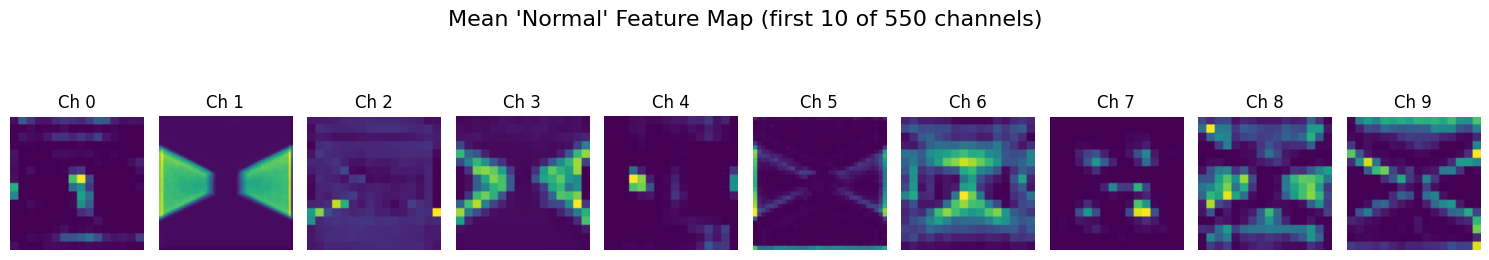

In [17]:
# --- 4. Visualize the Learned 'Normal' Mean ---
print("\n--- Visualization 4: The Learned 'Normal' Mean Feature Map ---")

# The learned_distribution contains [mean, covariance]
mean_features = learned_distribution[0] # Shape [Channels, Height*Width] e.g., [550, 1600]
num_channels, num_patches = mean_features.shape
patch_dim = int(np.sqrt(num_patches))
print(f"Mean array shape: {mean_features.shape}")

# Reshape to be plottable: [Channels, Height, Width]
mean_features_map = mean_features.reshape(num_channels, patch_dim, patch_dim)

# Plot a few channels of the mean feature map
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
fig.suptitle(f"Mean 'Normal' Feature Map (first 10 of {num_channels} channels)", fontsize=16)
for i in range(10):
    axes[i].imshow(mean_features_map[i], cmap='viridis')
    axes[i].set_title(f'Ch {i}')
    axes[i].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

The covariance matrix tells us how different features are related to each other for a single patch. A high value means two features tend to increase or decrease together (e.g., a "vertical edge" feature and a "shadow" feature might be correlated). The Mahalanobis distance uses this information to make a smarter comparison. We will visualize the covariance matrix for the patch at the very center of the image.

Now that we have our model of normalcy, we can score our test images. The process is similar to the training stage, but instead of calculating statistics, we measure deviation.

1. **Extract Test Features**: Pass each test image through the model to get its feature embeddings.

2. **Calculate Mahalanobis Distance**: For each patch in the test image's feature map, we calculate its Mahalanobis distance to the corresponding learned "normal" distribution. A large distance means the patch is "far" from normal and thus anomalous.
**Why Mahalanobis Distance?** Unlike standard Euclidean distance, Mahalanobis distance accounts for the correlation between features. If two features normally vary together, it won't penalize them, making it much more robust for this task.

3. **Create Anomaly Map**: The distances for all patches form a low-resolution anomaly map. We then use bilinear interpolation to resize it to the original image size and apply a Gaussian filter to smooth the results.

In [18]:
# --- Extract Features for the Test Set ---
print("Extracting features from the test set...")
test_feature_maps = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])
test_images_list = []
ground_truth_labels = []

for (image_batch, labels, _) in tqdm(test_dataloader, desc="Extracting test features"):
    test_images_list.extend(image_batch.cpu().detach().numpy())
    ground_truth_labels.extend(labels.cpu().detach().numpy())
    
    with torch.no_grad():
        _ = model(image_batch.to(DEVICE))
        
    for layer_name, feature_map in zip(test_feature_maps.keys(), intermediate_feature_maps):
        test_feature_maps[layer_name].append(feature_map.cpu().detach())
    
    intermediate_feature_maps = []

for layer_name, feature_list in test_feature_maps.items():
    test_feature_maps[layer_name] = torch.cat(feature_list, 0)

# Concatenate and reduce test features just as we did for training features
embedding_vectors_test = test_feature_maps['layer1']
for layer_name in ['layer2', 'layer3']:
    embedding_vectors_test = concatenate_embeddings(embedding_vectors_test, test_feature_maps[layer_name])

embedding_vectors_test = torch.index_select(embedding_vectors_test, 1, random_feature_indices).to(DEVICE)

# --- Calculate Mahalanobis Distance ---
print("Calculating Mahalanobis distances to generate anomaly scores...")
B, C, H, W = embedding_vectors_test.size()
embedding_vectors_test = embedding_vectors_test.view(B, C, H * W)

# Move learned distribution to the GPU for faster calculation
mean_vectors_gpu = torch.tensor(learned_distribution[0], device=DEVICE)
covariance_matrices_gpu = torch.tensor(learned_distribution[1], device=DEVICE)

mahalanobis_distances = []
for i in range(H * W): # Iterate over each patch location
    mean_patch = mean_vectors_gpu[:, i]
    cov_inv_patch = torch.linalg.inv(covariance_matrices_gpu[:, :, i])
    
    test_samples_patch = embedding_vectors_test[:, :, i] # Shape [Batch, Channels]
    
    # Calculate Mahalanobis distance for all samples in the batch for this patch
    diff = test_samples_patch - mean_patch
    dist = torch.sqrt(torch.einsum('bi,ij,bj->b', diff, cov_inv_patch, diff))
    mahalanobis_distances.append(dist.cpu().numpy())

# --- Create Anomaly Maps ---
# Reshape the distances into low-resolution anomaly maps
anomaly_maps_raw = np.array(mahalanobis_distances).transpose(1, 0).reshape(B, H, W)

# Upsample and smooth the maps
score_maps = F.interpolate(
    torch.tensor(anomaly_maps_raw).unsqueeze(1), 
    size=CROPSIZE, 
    mode='bilinear', 
    align_corners=False
).squeeze().numpy()

for i in range(score_maps.shape[0]):
    score_maps[i] = gaussian_filter(score_maps[i], sigma=4)

print("--- Anomaly score generation complete. ---")

Extracting features from the test set...


Extracting test features: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Calculating Mahalanobis distances to generate anomaly scores...


KeyboardInterrupt: 

Finally, we evaluate our model's performance.

1. **Normalize Scores**: We normalize the anomaly maps to a 0-1 range for consistency.

2. **Image-Level Score**: The final anomaly score for an entire image is taken as the maximum score from its anomaly map.

3. **ROC AUC Score**: We use the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) to measure performance. An AUC of 1.0 is a perfect classifier, while 0.5 is no better than random guessing.

We will then plot the ROC curve and save visualizations of the heatmap overlays for each test image.

In [ ]:
# --- Normalize Scores ---
max_score = score_maps.max()
min_score = score_maps.min()
normalized_scores = (score_maps - min_score) / (max_score - min_score)

# --- Calculate Image-Level Scores and ROC AUC ---
image_level_anomaly_scores = normalized_scores.reshape(normalized_scores.shape[0], -1).max(axis=1)
ground_truth_labels = np.asarray(ground_truth_labels)
false_positive_rate, true_positive_rate, _ = roc_curve(ground_truth_labels, image_level_anomaly_scores)
image_roc_auc = roc_auc_score(ground_truth_labels, image_level_anomaly_scores)

Image-level ROC AUC for class '116': 0.950
AUROC score saved to: ./results/wide_resnet50_2_resize-512_crop-400/116/results.txt
ROC curve plot saved to: ./results/wide_resnet50_2_resize-512_crop-400/116/roc_curve.png


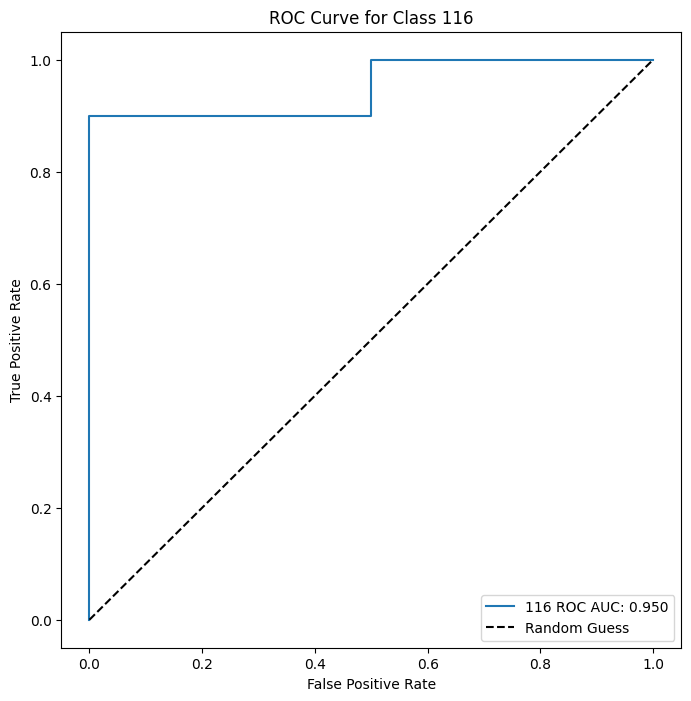

Score distribution plot saved to: ./results/wide_resnet50_2_resize-512_crop-400/116/score_distribution.png


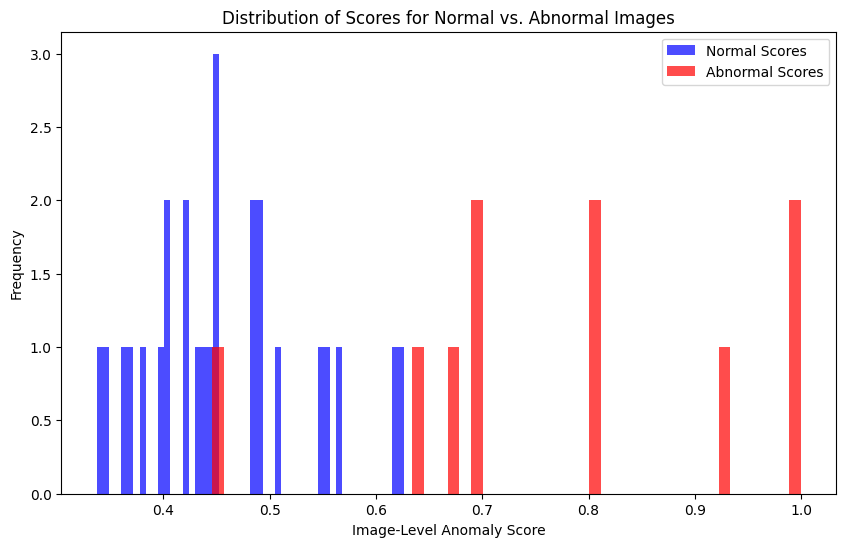

In [ ]:
print(f"Image-level ROC AUC for class '{CLASS_NAME}': {image_roc_auc:.3f}")

# --- Save the AUROC score to a text file ---
results_filepath = os.path.join(CLASS_SAVE_DIR, 'results.txt')
with open(results_filepath, 'w') as f:
    f.write(f"Image-level ROC AUC: {image_roc_auc:.4f}\n")
print(f"AUROC score saved to: {results_filepath}")


# --- Create, Save, and Display the ROC Curve Plot ---
roc_curve_fig = plt.figure(figsize=(8, 8))
plt.plot(false_positive_rate, true_positive_rate, label=f'{CLASS_NAME} ROC AUC: {image_roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Class {CLASS_NAME}')
plt.legend(loc='lower right')
roc_curve_path = os.path.join(CLASS_SAVE_DIR, 'roc_curve.png')
roc_curve_fig.savefig(roc_curve_path)
print(f"ROC curve plot saved to: {roc_curve_path}")
plt.show()


# --- Create, Save, and Display the Score Distribution Plot ---
score_dist_fig = plt.figure(figsize=(10, 6))
normal_scores = image_level_anomaly_scores[ground_truth_labels == 0]
abnormal_scores = image_level_anomaly_scores[ground_truth_labels == 1]
plt.hist(normal_scores, bins=50, label='Normal Scores', color='blue', alpha=0.7)
plt.hist(abnormal_scores, bins=50, label='Abnormal Scores', color='red', alpha=0.7)
plt.xlabel("Image-Level Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Scores for Normal vs. Abnormal Images")
plt.legend()
score_dist_path = os.path.join(CLASS_SAVE_DIR, 'score_distribution.png')
score_dist_fig.savefig(score_dist_path)
print(f"Score distribution plot saved to: {score_dist_path}")
plt.show()

In [ ]:
def plot_and_save_results(
    test_images, raw_anomaly_maps, normalized_scores, image_level_scores, save_directory, test_filepaths
):
    """
    Generates and saves a 4-panel visualization for each test image:
    1. Original Image
    2. Raw, low-resolution anomaly map
    3. Upscaled heatmap overlay with the final anomaly score
    4. Histogram of the raw patch anomaly scores (Mahalanobis distances)
    """
    num_images = len(test_images)

    for i in range(num_images):
        # --- Prepare data for the current image ---
        img_original = test_images[i]
        img_denormalized = denormalize_image_for_display(img_original)
        raw_map = raw_anomaly_maps[i]
        final_heatmap = normalized_scores[i]
        score = image_level_scores[i]

        # --- Filename generation ---
        filepath = test_filepaths[i]
        defect_type = os.path.basename(os.path.dirname(filepath))
        image_filename = os.path.splitext(os.path.basename(filepath))[0]
        save_filename = f"{defect_type}_{image_filename}.png"

        # --- Create the 4-panel plot ---
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        fig.suptitle(f"Anomaly Analysis for: {save_filename}", y=1.02)

        # 1. Original Image
        axes[0].imshow(img_denormalized)
        axes[0].set_title("1. Original Image")
        axes[0].axis("off")
        
        # 4. Distribution of Raw Anomaly Scores
        patch_scores = raw_map.ravel()
        axes[1].hist(patch_scores, bins=60, color='skyblue', edgecolor='black')
        axes[1].set_title("4. Patch Score Distribution")
        axes[1].set_xlabel("Mahalanobis Distance")
        axes[1].set_ylabel("Frequency")
        axes[1].grid(axis='y', alpha=0.6)

        # 2. Raw Anomaly Map
        im = axes[2].imshow(raw_map, cmap="jet")
        axes[2].set_title("2. Raw Anomaly Map")
        axes[2].axis("off")
        fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

        # 3. Final Heatmap Overlay
        axes[3].imshow(img_denormalized)
        axes[3].imshow(final_heatmap, cmap="jet", alpha=0.5)
        axes[3].set_title("3. Final Heatmap Overlay")
        axes[3].axis("off")
        axes[3].text(
            5, 20, f"Anomaly Score: {score:.3f}",
            color="white", backgroundcolor="black",
        )

        # Save and close the figure
        plt.tight_layout()
        fig.savefig(os.path.join(save_directory, save_filename), dpi=120, bbox_inches='tight')
        plt.close(fig)

In [ ]:
test_filepaths = data_manager.test.image_filepaths

In [ ]:
# --- Save Heatmap Visualizations of Test Results ---
visualization_dir = os.path.join(CLASS_SAVE_DIR, 'visualizations')
os.makedirs(visualization_dir, exist_ok=True)
print(f"Saving heatmap visualizations...")
plot_and_save_results(
    test_images_list,
    anomaly_maps_raw,
    normalized_scores,
    image_level_anomaly_scores,
    visualization_dir,
    test_filepaths,
)
print(f"Visualizations saved to: {visualization_dir}")

Saving heatmap visualizations...
Visualizations saved to: ./results/wide_resnet50_2_resize-512_crop-400/116/visualizations



--- Visualization: Generating Separate and Overlaid Patch Score Distributions ---

1. Normal patch score distribution plot saved to: ./results/wide_resnet50_2_resize-512_crop-400/116/patch_score_distribution_normal.png


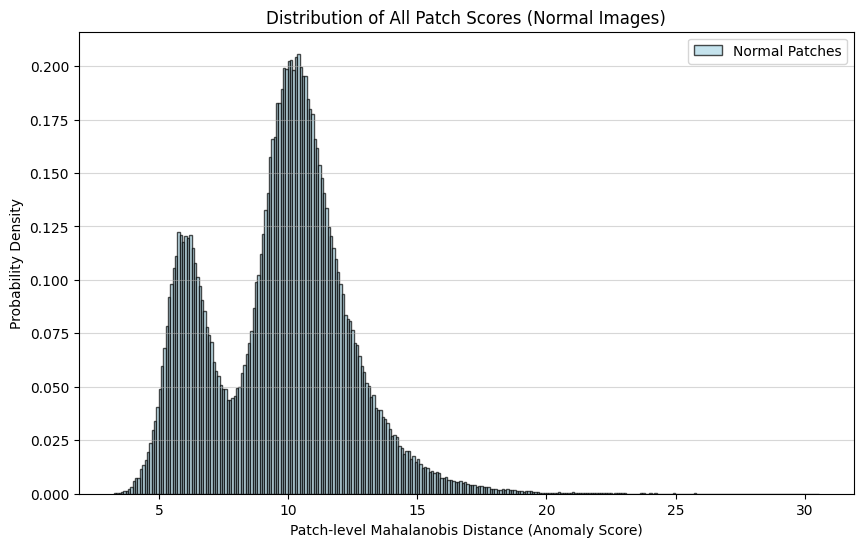

2. Abnormal patch score distribution plot saved to: ./results/wide_resnet50_2_resize-512_crop-400/116/patch_score_distribution_abnormal.png


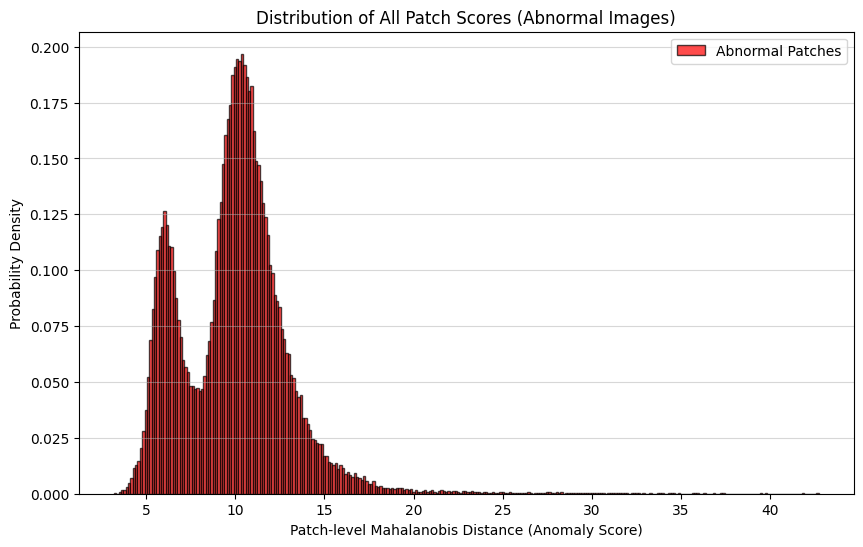

3. Comparative patch score distribution plot saved to: ./results/wide_resnet50_2_resize-512_crop-400/116/patch_score_distribution_comparative.png


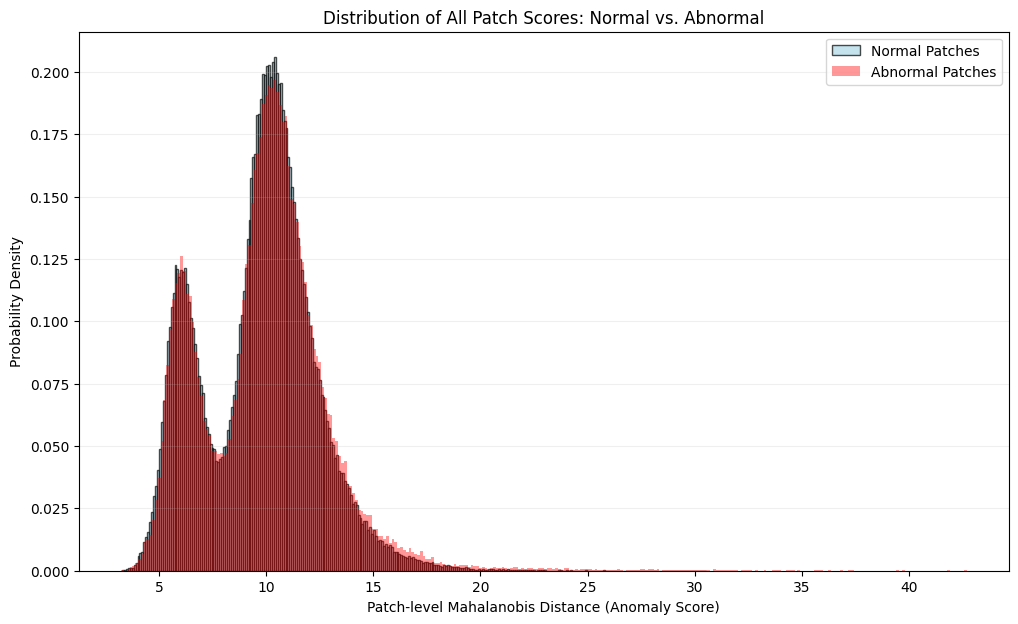

In [ ]:
bins = 300

# --- Detailed Patch Score Distributions (Separate & Overlaid) ---
print("\n--- Visualization: Generating Separate and Overlaid Patch Score Distributions ---")

# --- Data Preparation ---
# Separate the raw anomaly maps based on their ground truth label
normal_indices = np.where(ground_truth_labels == 0)[0]
abnormal_indices = np.where(ground_truth_labels == 1)[0]

# --- 1. Plot for Normal Patches ---
if len(normal_indices) > 0:
    normal_raw_maps = anomaly_maps_raw[normal_indices]
    all_normal_patch_scores = normal_raw_maps.flatten()

    plt.figure(figsize=(10, 6))
    plt.hist(all_normal_patch_scores, bins=bins, label='Normal Patches', color='lightblue', alpha=0.7, density=True, edgecolor='black')
    plt.title('Distribution of All Patch Scores (Normal Images)')
    plt.xlabel('Patch-level Mahalanobis Distance (Anomaly Score)')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(axis='y', alpha=0.5)

    normal_dist_path = os.path.join(CLASS_SAVE_DIR, "patch_score_distribution_normal.png")
    plt.savefig(normal_dist_path)
    print(f"\n1. Normal patch score distribution plot saved to: {normal_dist_path}")
    plt.show()
else:
    print("\n1. Skipping normal patch score plot: No normal images found in the test set.")


# --- 2. Plot for Abnormal Patches ---
if len(abnormal_indices) > 0:
    abnormal_raw_maps = anomaly_maps_raw[abnormal_indices]
    all_abnormal_patch_scores = abnormal_raw_maps.flatten()

    plt.figure(figsize=(10, 6))
    plt.hist(all_abnormal_patch_scores, bins=bins, label='Abnormal Patches', color='red', alpha=0.7, density=True, edgecolor='black')
    plt.title('Distribution of All Patch Scores (Abnormal Images)')
    plt.xlabel('Patch-level Mahalanobis Distance (Anomaly Score)')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(axis='y', alpha=0.5)

    abnormal_dist_path = os.path.join(CLASS_SAVE_DIR, "patch_score_distribution_abnormal.png")
    plt.savefig(abnormal_dist_path)
    print(f"2. Abnormal patch score distribution plot saved to: {abnormal_dist_path}")
    plt.show()
else:
    print("\n2. Skipping abnormal patch score plot: No abnormal images found in the test set.")


# --- 3. Plot for Overlaid Patches ---
if len(normal_indices) > 0 and len(abnormal_indices) > 0:
    # We can reuse the flattened arrays from the plots above
    plt.figure(figsize=(12, 7))
    plt.hist(all_normal_patch_scores, bins=bins, label='Normal Patches', color='lightblue', alpha=0.7, density=True, edgecolor='black')
    plt.hist(all_abnormal_patch_scores, bins=bins, label='Abnormal Patches', color='red', alpha=0.4, density=True)

    plt.title('Distribution of All Patch Scores: Normal vs. Abnormal')
    plt.xlabel('Patch-level Mahalanobis Distance (Anomaly Score)')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(axis='y', alpha=0.2)
    
    comp_dist_path = os.path.join(CLASS_SAVE_DIR, "patch_score_distribution_comparative.png")
    plt.savefig(comp_dist_path)
    print(f"3. Comparative patch score distribution plot saved to: {comp_dist_path}")
    plt.show()
else:
    print("\n3. Skipping comparative plot: Both normal and abnormal images are required.")



--- Visualization 6-9: The Full Anomaly Scoring Pipeline ---
Visualizing a known anomalous image at index 26.


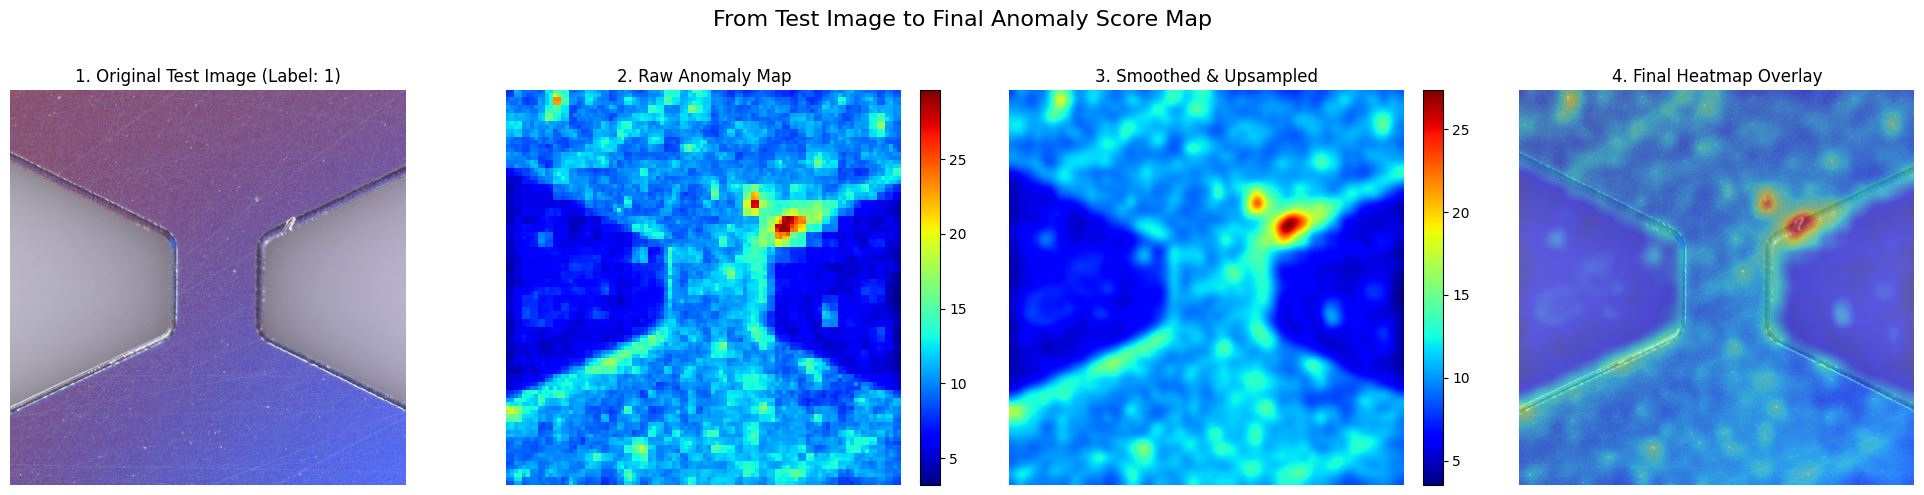

In [ ]:
# --- 6-9. Visualize the Anomaly Map Generation Pipeline ---
print("\n--- Visualization 6-9: The Full Anomaly Scoring Pipeline ---")

# Let's find an anomalous image to visualize, if one exists in the batch
# Find the index of the first true anomaly in our test set
try:
    anomaly_index = list(ground_truth_labels).index(1)
    print(f"Visualizing a known anomalous image at index {anomaly_index}.")
except ValueError:
    anomaly_index = 0 # Default to the first image if no anomalies are in the batch
    print("No anomalies in this batch, visualizing the first image.")

# The 'anomaly_maps_raw' variable holds the map before upsampling
raw_anomaly_map = anomaly_maps_raw[anomaly_index]

# The 'score_maps' variable holds the upsampled and smoothed map
final_anomaly_map = score_maps[anomaly_index]

# The 'normalized_scores' is the final version
normalized_anomaly_map = normalized_scores[anomaly_index]

# Get the original test image for comparison
original_test_image = test_images_list[anomaly_index]

# Create the plot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("From Test Image to Final Anomaly Score Map", fontsize=16)

# 1. Original Test Image
axes[0].imshow(denormalize_image_for_display(original_test_image))
axes[0].set_title(f"1. Original Test Image (Label: {ground_truth_labels[anomaly_index]})")
axes[0].axis('off')

# 2. Raw Anomaly Map (Mahalanobis Distances)
im1 = axes[1].imshow(raw_anomaly_map, cmap='jet')
axes[1].set_title("2. Raw Anomaly Map")
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 3. Smoothed & Upsampled Anomaly Map
im2 = axes[2].imshow(final_anomaly_map, cmap='jet')
axes[2].set_title("3. Smoothed & Upsampled")
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

# 4. Final Heatmap Overlay
axes[3].imshow(denormalize_image_for_display(original_test_image))
axes[3].imshow(normalized_anomaly_map, cmap='jet', alpha=0.5)
axes[3].set_title("4. Final Heatmap Overlay")
axes[3].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


--- Visualization: Calculating and displaying mean anomaly maps ---
Calculated mean maps for 26 normal images.
Calculated mean maps for 10 anomalous images.

Mean anomaly map comparison plot saved to: ./results/wide_resnet50_2_resize-512_crop-400/116/mean_anomaly_maps_comparison.png


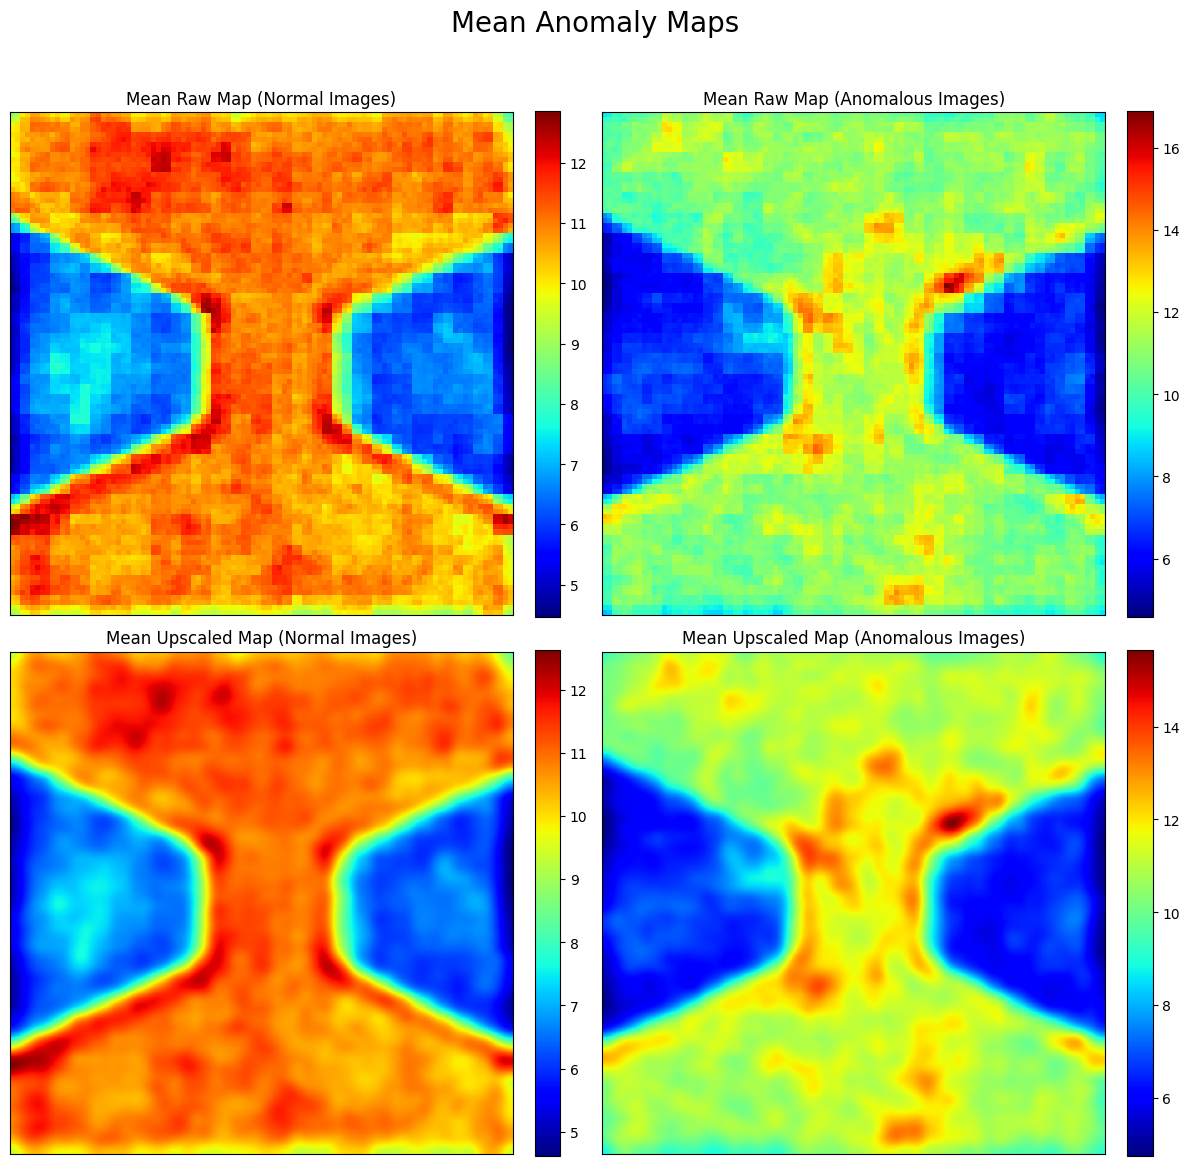

In [ ]:
# --- Calculate and Display Mean Anomaly Maps ---
print("\n--- Visualization: Calculating and displaying mean anomaly maps ---")

# --- 1. Separate the anomaly maps based on their ground truth label ---
normal_indices = np.where(ground_truth_labels == 0)[0]
anomalous_indices = np.where(ground_truth_labels == 1)[0]

# --- 2. Calculate the mean of each group of maps ---
# Initialize with zeros in case a category has no images
mean_raw_normal = np.zeros_like(anomaly_maps_raw[0])
mean_upscaled_normal = np.zeros_like(score_maps[0])
mean_raw_anomalous = np.zeros_like(anomaly_maps_raw[0])
mean_upscaled_anomalous = np.zeros_like(score_maps[0])

# Calculate means if images for the category exist
if len(normal_indices) > 0:
    mean_raw_normal = np.mean(anomaly_maps_raw[normal_indices], axis=0)
    mean_upscaled_normal = np.mean(score_maps[normal_indices], axis=0)
    print(f"Calculated mean maps for {len(normal_indices)} normal images.")
else:
    print("No normal images found in the test set to create a mean map.")

if len(anomalous_indices) > 0:
    mean_raw_anomalous = np.mean(anomaly_maps_raw[anomalous_indices], axis=0)
    mean_upscaled_anomalous = np.mean(score_maps[anomalous_indices], axis=0)
    print(f"Calculated mean maps for {len(anomalous_indices)} anomalous images.")
else:
    print("No anomalous images found in the test set to create a mean map.")


# --- 3. Create the 2x2 plot ---
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Mean Anomaly Maps", fontsize=20)

# --- Top Row: Raw (Non-upscaled) Maps ---
# Good/Normal
im1 = axes[0, 0].imshow(mean_raw_normal, cmap='jet')
axes[0, 0].set_title("Mean Raw Map (Normal Images)")
axes[0, 0].axes.xaxis.set_visible(False)
axes[0, 0].axes.yaxis.set_visible(False)
fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)

# Bad/Anomalous
im2 = axes[0, 1].imshow(mean_raw_anomalous, cmap='jet')
axes[0, 1].set_title("Mean Raw Map (Anomalous Images)")
axes[0, 1].axes.xaxis.set_visible(False)
axes[0, 1].axes.yaxis.set_visible(False)
fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)

# --- Bottom Row: Upscaled Maps ---
# Good/Normal
im3 = axes[1, 0].imshow(mean_upscaled_normal, cmap='jet')
axes[1, 0].set_title("Mean Upscaled Map (Normal Images)")
axes[1, 0].axes.xaxis.set_visible(False)
axes[1, 0].axes.yaxis.set_visible(False)
fig.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)

# Bad/Anomalous
im4 = axes[1, 1].imshow(mean_upscaled_anomalous, cmap='jet')
axes[1, 1].set_title("Mean Upscaled Map (Anomalous Images)")
axes[1, 1].axes.xaxis.set_visible(False)
axes[1, 1].axes.yaxis.set_visible(False)
fig.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)


# --- Save and Show Plot ---
mean_maps_path = os.path.join(CLASS_SAVE_DIR, "mean_anomaly_maps_comparison.png")
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig(mean_maps_path)
print(f"\nMean anomaly map comparison plot saved to: {mean_maps_path}")
plt.show()

In [ ]:
# --- 1. Find the Optimal Threshold from the ROC Curve ---
# The roc_curve function returns fpr, tpr, and the thresholds it used to calculate them
# We rename the third output from '_' to 'thresholds' for clarity
false_positive_rate, true_positive_rate, thresholds = roc_curve(
    ground_truth_labels, image_level_anomaly_scores
)

# Calculate the G-Mean for each threshold. The G-Mean is a good metric for imbalanced data.
# It measures the balance between sensitivity (TPR) and specificity (1 - FPR).
gmeans = np.sqrt(true_positive_rate * (1 - false_positive_rate))

# Locate the index of the largest G-Mean
best_gmean_index = np.argmax(gmeans)
optimal_threshold = thresholds[best_gmean_index]

print(f"--- Confusion Matrix Analysis ---")
print(f"Best Threshold found: {optimal_threshold:.4f}")
print(f"  At this threshold:")
print(f"  - True Positive Rate (Sensitivity): {true_positive_rate[best_gmean_index]:.4f}")
print(f"  - False Positive Rate: {false_positive_rate[best_gmean_index]:.4f}")


--- Confusion Matrix Analysis ---
Best Threshold found: 0.6410
  At this threshold:
  - True Positive Rate (Sensitivity): 0.9000
  - False Positive Rate: 0.0000



Confusion Matrix:
  - True Negatives (Correctly Normal): 26
  - False Positives (Normal as Anomaly): 0
  - False Negatives (Anomaly as Normal): 1
  - True Positives (Correctly Anomaly): 9

Confusion matrix plot saved to: ./results/wide_resnet50_2_resize-512_crop-400/116/confusion_matrix.png


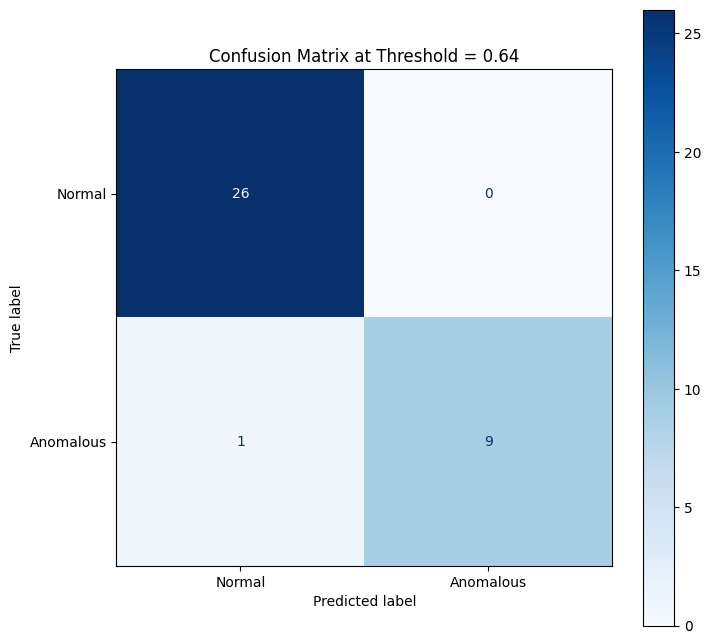

In [ ]:
# --- 2. Apply Threshold to Get Predictions ---
# Convert continuous scores to binary predictions using the optimal threshold
predictions = (image_level_anomaly_scores >= optimal_threshold).astype(int)


# --- 3. Calculate and Plot the Confusion Matrix ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(ground_truth_labels, predictions)

print("\nConfusion Matrix:")
print(f"  - True Negatives (Correctly Normal): {cm[0, 0]}")
print(f"  - False Positives (Normal as Anomaly): {cm[0, 1]}")
print(f"  - False Negatives (Anomaly as Normal): {cm[1, 0]}")
print(f"  - True Positives (Correctly Anomaly): {cm[1, 1]}")


# Plot the visual confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomalous'])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='g')
plt.title(f"Confusion Matrix at Threshold = {optimal_threshold:.2f}")

# Save and show the plot
cm_path = os.path.join(CLASS_SAVE_DIR, "confusion_matrix.png")
plt.savefig(cm_path)
print(f"\nConfusion matrix plot saved to: {cm_path}")
plt.show()
